In [72]:
#import all the libaries neccessary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve, precision_recall_curve

In [73]:
#read csv file

df = pd.read_csv("heart.csv")

In [74]:
#Check the data types of variables in dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [75]:
# Encode categorical variables to numerical values

df_encoded = df.copy()
label_encoders = {}

cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

for col in cat_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])

In [76]:
#Basic information about the dataset
df_encoded.describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,0.781046,132.396514,198.799564,0.233115,0.989107,136.809368,0.404139,0.887364,1.361656,0.553377
std,9.432617,0.407701,0.956519,18.514154,109.384145,0.423046,0.631671,25.460334,0.490992,1.066570,0.607056,0.497414
min,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,0.000000,120.000000,173.250000,0.000000,1.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,0.000000,130.000000,223.000000,0.000000,1.000000,138.000000,0.000000,0.600000,1.000000,1.000000
75%,60.000000,1.000000,2.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,1.000000


In [77]:
#Check for duplicate rows

print(f"Number of duplicate rows: {df_encoded.duplicated().sum()}")

Number of duplicate rows: 0


In [78]:
#Check for null values

print(f"Number of null cells:\n{df_encoded.isnull().sum()}")

Number of null cells:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [79]:
#Calculate median without zero values

restingbp = df[df['RestingBP'] > 0]['RestingBP'].median()
cholesterol = df[df['Cholesterol'] > 0]['Cholesterol'].median()

#Replace zeros with median values

df_clean = df_encoded.copy()
df_clean['RestingBP'] = df_clean['RestingBP'].replace(0, restingbp)
df_clean['Cholesterol'] = df_clean['Cholesterol'].replace(0, cholesterol)

C:\Users\vikal\AppData\Local\Temp\ipykernel_17892\3633862986.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='HeartDisease', data=df_clean, palette="mako")


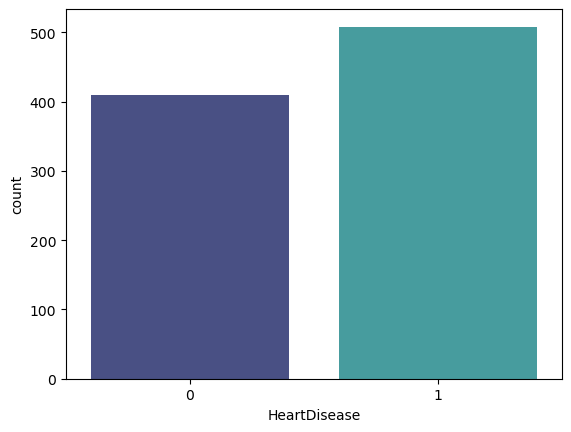

In [80]:
#Check balance between two classes
X = df_clean.drop('HeartDisease', axis=1)
y = df_clean['HeartDisease']

#Graph the distribution of the 'HeartDisease' column
sns.countplot(x='HeartDisease', data=df_clean, palette="mako")
plt.show()

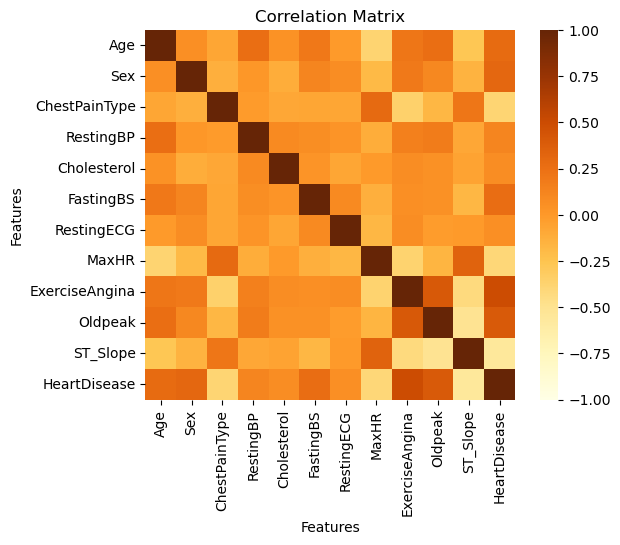

In [81]:
#Correlation Matrix for data

cm = df_clean.corr()
sns.heatmap(cm,
    vmin=-1, vmax=1, center=0,
    cmap=sns.color_palette("YlOrBr", as_cmap=True),
    square=True
)
plt.ylabel('Features')
plt.xlabel('Features')
plt.title('Correlation Matrix')

plt.show()

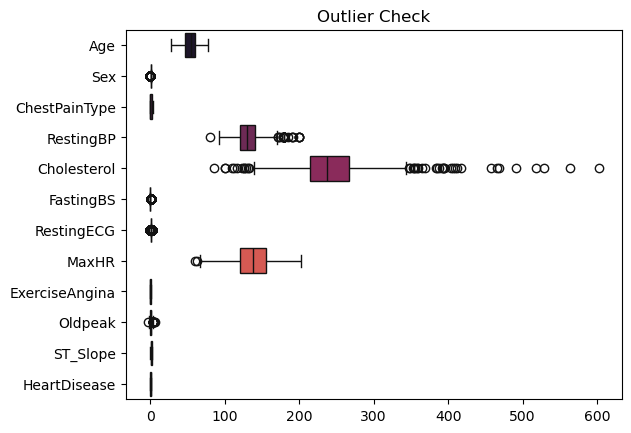

In [82]:
#Check for outliers using boxplots
outlier_check = sns.boxplot(data=df_clean, orient="h", palette="rocket")
outlier_check.set_title("Outlier Check")
plt.show()

In [83]:
#Split data into train, test and validation sets

X = df_clean.drop('HeartDisease', axis=1)
y = df_clean['HeartDisease']

X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,
                                              train_size=0.8,
                                              random_state=42,
                                              stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                y_val_test,
                                                test_size=0.5,
                                                random_state=42,
                
)

In [84]:
#Define the paramter grid for hyperparamater tuning using GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500],
    'class_weight': [None, 'balanced']
}

In [85]:
#Fit the GridSearch on Logistic Regression

lr = LogisticRegression(random_state=42)

grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
)

grid_search.fit(X_val, y_val)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'max_iter': [100, 200, 500], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [86]:
#Final results of GridSearchCV

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", f"{grid_search.best_score_:.4f}")

Best parameters: {'C': 100, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.7930


In [87]:
#Setup LogisticRegression using parameters using GridSearchCV
lr = LogisticRegression(C=100,
                          class_weight='balanced',
                          max_iter=100,
                          penalty='l1',
                          solver='liblinear')

#Train the Logistic Regression model on the training data
lr.fit(X_train, y_train)

#Make predictions on the test set
pred = lr.predict(X_test)

#Get probability predictions for both training and test sets
prob_train = lr.predict_proba(X_train) [:,1]
prob_test = lr.predict_proba(X_test) [:,1]

#Evaluate model performance using classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        41
           1       0.90      0.88      0.89        51

    accuracy                           0.88        92
   macro avg       0.88      0.88      0.88        92
weighted avg       0.88      0.88      0.88        92



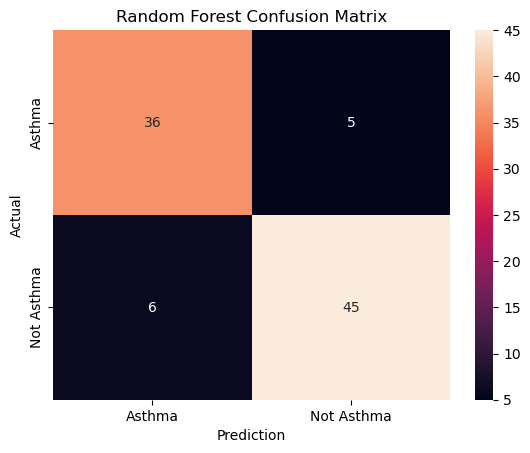

In [88]:
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm,
    annot=True,
    fmt='g',
    xticklabels=['Asthma','Not Asthma'],
    yticklabels=['Asthma','Not Asthma']
)
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.title('Random Forest Confusion Matrix')

plt.show()

Text(0.5, 1.0, 'Feature Importance for Logistic Regression')

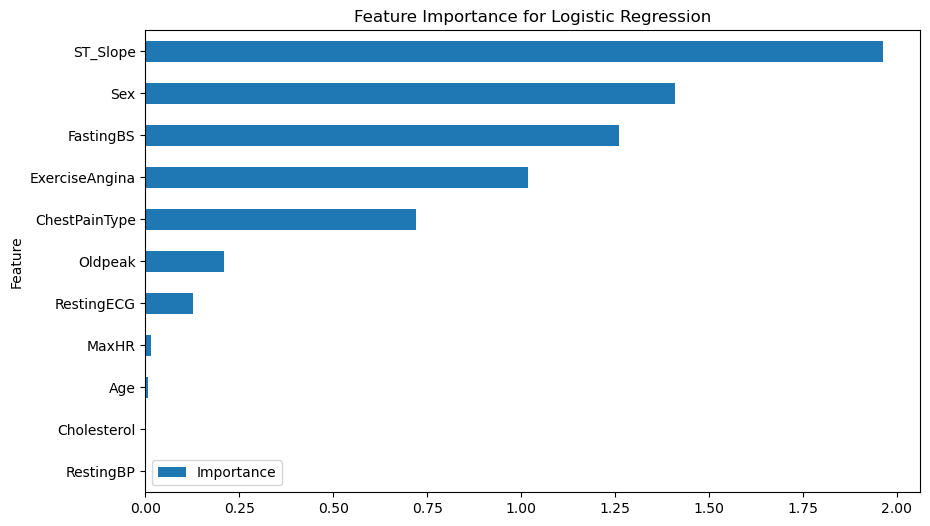

In [89]:
#Feature importance for model

coefficients = lr.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Feature Importance for Logistic Regression')

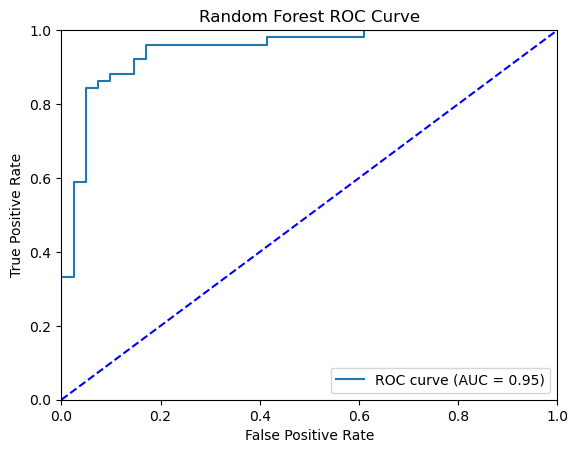

In [90]:
#Create ROC curve
fpr, tpr, thresholds = roc_curve(y_test, prob_test)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.show()

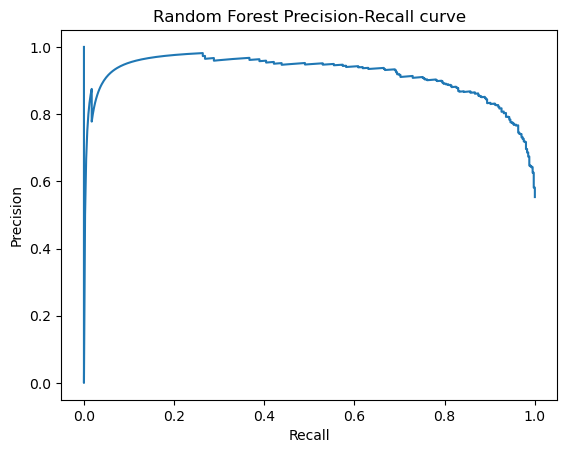

In [91]:
#Create Precision Recall Curve  
precision, recall, thresholds = precision_recall_curve(y_train, prob_train)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Random Forest Precision-Recall curve")
plt.plot(recall, precision)
plt.show()